<a href="https://colab.research.google.com/github/thak123/winter-school-ffzg-2023/blob/main/2_Day_2_Text_classification_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

In [ ]:
pip install -U scikit-learn pandas numpy matplotlib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 26.4 MB/s eta 0:00:00
ERROR: Operation cancelled by user


# Classification

In [ ]:

from pathlib import Path
from hashlib import sha256
import tarfile
from urllib.request import urlopen


URL = "http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"

ARCHIVE_SHA256 = "fc0dccc2671af5db3c5d8f81f77a1ebfec953ecdd422334062df61ede36b2179"
ARCHIVE_NAME = Path(URL.rsplit("/", 1)[1])
DATA_FOLDER = Path("txt_sentoken")


if not DATA_FOLDER.exists():

    if not ARCHIVE_NAME.exists():
        print("Downloading dataset from %s (3 MB)" % URL)
        opener = urlopen(URL)
        with open(ARCHIVE_NAME, "wb") as archive:
            archive.write(opener.read())

    try:
        print("Checking the integrity of the archive")
        assert sha256(ARCHIVE_NAME.read_bytes()).hexdigest() == ARCHIVE_SHA256

        print("Decompressing %s" % ARCHIVE_NAME)
        with tarfile.open(ARCHIVE_NAME, "r:gz") as archive:
            archive.extractall(path=".")

    finally:
        ARCHIVE_NAME.unlink()

Checking the integrity of the archive
Decompressing review_polarity.tar.gz


In [ ]:
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# the training data folder must be passed as first argument
dataset = load_files(DATA_FOLDER, shuffle=False)
print("n_samples: %d" % len(dataset.data))

n_samples: 2000


In [ ]:
# split the dataset in training and test set:
docs_train, docs_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.25, random_state=42)

## Classification using Gridsearch

In [ ]:



# TASK: Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=3, max_df=0.95)),
    ('clf', SVC(C=10.0, 
          kernel='rbf', 
          gamma=0.1, 
          decision_function_shape='ovr')),
])

# TASK: Build a grid search to find out whether unigrams or bigrams are
# more useful.
# Fit the pipeline on the training set using grid search for the parameters
parameters = {
    # "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    # "vect__min_df": (1, 3, 5, 10),
    # "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # "vect__norm": ("l1", "l2"),

    'clf__C': [1, 10, 100, 1000], 
    # 'clf__gamma': [0.001, 0.0001], 
    'clf__kernel': ['rbf'],
}
grid_search = GridSearchCV(pipeline, parameters,cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(docs_train, y_train)

# TASK: print the mean and std for each candidate along with the parameter
# settings for all the candidates explored by grid search.
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'
                % (grid_search.cv_results_['params'][i],
                grid_search.cv_results_['mean_test_score'][i],
                grid_search.cv_results_['std_test_score'][i]))

# TASK: Predict the outcome on the testing set and store it in a variable
# named y_predicted
y_predicted = grid_search.predict(docs_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

# import matplotlib.pyplot as plt
# plt.matshow(cm)
# plt.show()

KeyboardInterrupt: ignored

In [ ]:
grid_search.best_score_,grid_search.best_params_,grid_search.n_splits_,grid_search.cv_results_


# Clustering


In [ ]:
from collections import defaultdict
import operator
from time import time

import numpy as np

from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score


def number_normalizer(tokens):
    """Map all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)


class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))


# exclude 'comp.os.ms-windows.misc'
categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc",
]

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

newsgroups = fetch_20newsgroups(categories=categories)
y_true = newsgroups.target

vectorizer = NumberNormalizingVectorizer(stop_words="english", min_df=5)
cocluster = SpectralCoclustering(
    n_clusters=len(categories), svd_method="arpack", random_state=0
)
kmeans = MiniBatchKMeans(
    n_clusters=len(categories), batch_size=20000, random_state=0, n_init=3
)

print("Vectorizing...")
X = vectorizer.fit_transform(newsgroups.data)

print("Coclustering...")
start_time = time()
cocluster.fit(X)
y_cocluster = cocluster.row_labels_
print(
    "Done in {:.2f}s. V-measure: {:.4f}".format(
        time() - start_time, v_measure_score(y_cocluster, y_true)
    )
)

print("MiniBatchKMeans...")
start_time = time()
y_kmeans = kmeans.fit_predict(X)
print(
    "Done in {:.2f}s. V-measure: {:.4f}".format(
        time() - start_time, v_measure_score(y_kmeans, y_true)
    )
)

feature_names = vectorizer.get_feature_names_out()
document_names = list(newsgroups.target_names[i] for i in newsgroups.target)


def bicluster_ncut(i):
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys

        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    # Note: the following is identical to X[rows[:, np.newaxis],
    # cols].sum() but much faster in scipy <= 0.16
    weight = X[rows][:, cols].sum()
    cut = X[row_complement][:, cols].sum() + X[rows][:, col_complement].sum()
    return cut / weight


def most_common(d):
    """Items of a defaultdict(int) with the highest values.

    Like Counter.most_common in Python >=2.7.
    """
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)


bicluster_ncuts = list(bicluster_ncut(i) for i in range(len(newsgroups.target_names)))
best_idx = np.argsort(bicluster_ncuts)[:5]

print()
print("Best biclusters:")
print("----------------")
for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # categories
    counter = defaultdict(int)
    for i in cluster_docs:
        counter[document_names[i]] += 1
    cat_string = ", ".join(
        "{:.0f}% {}".format(float(c) / n_rows * 100, name)
        for name, c in most_common(counter)[:3]
    )

    # words
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = X[:, cluster_words]
    word_scores = np.array(
        word_col[cluster_docs, :].sum(axis=0)
        - word_col[out_of_cluster_docs, :].sum(axis=0)
    )
    word_scores = word_scores.ravel()
    important_words = list(
        feature_names[cluster_words[i]] for i in word_scores.argsort()[:-11:-1]
    )

    print("bicluster {} : {} documents, {} words".format(idx, n_rows, n_cols))
    print("categories   : {}".format(cat_string))
    print("words        : {}\n".format(", ".join(important_words)))

Vectorizing...
Coclustering...
Done in 1.13s. V-measure: 0.4866
MiniBatchKMeans...
Done in 0.14s. V-measure: 0.4247

Best biclusters:
----------------
bicluster 0 : 566 documents, 2015 words
categories   : 66% alt.atheism, 34% talk.religion.misc
words        : keith, sandvik, god, livesey, morality, objective, jesus, kent, caltech, atheists

bicluster 1 : 905 documents, 2519 words
categories   : 56% sci.space, 43% comp.graphics, 1% talk.religion.misc
words        : space, #NUMBER, henry, toronto, access, alaska, digex, pat, launch, moon

bicluster 2 : 223 documents, 867 words
categories   : 82% comp.graphics, 18% sci.space
words        : egalon, ___, larc, nl, bezier, diablo, ati, oeinck, curves, oliveira

bicluster 3 : 340 documents, 2025 words
categories   : 53% talk.religion.misc, 31% alt.atheism, 12% sci.space
words        : thyagi, portal, archer, greek, catholic, hare, abortion, joshua, pegasus, cup



In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
from matplotlib import cm

In [ ]:
X

<2034x7426 sparse matrix of type '<class 'numpy.float64'>'
	with 185471 stored elements in Compressed Sparse Row format>

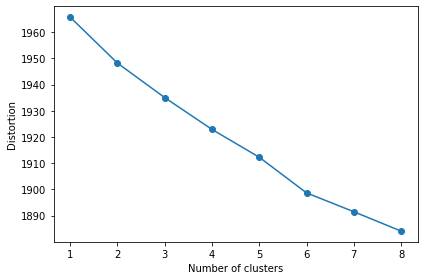

In [ ]:
distortions = []
for i in range(1, 9):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    # km = MiniBatchKMeans(
    # n_clusters=i, batch_size=20000, random_state=0, n_init=3
    # )
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 9), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('figures/10_03.png', dpi=300)
plt.show()

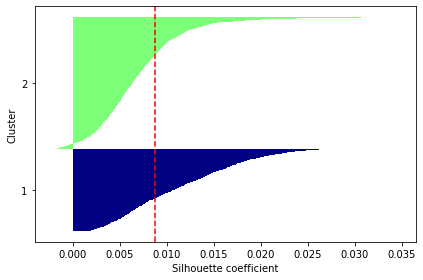

In [ ]:
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

# km = MiniBatchKMeans(
#     n_clusters=3, batch_size=20000, random_state=0, n_init=3
#     )

y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('figures/10_04.png', dpi=300)
plt.show()

In [ ]:
! pip install yellowbrick

In [ ]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn

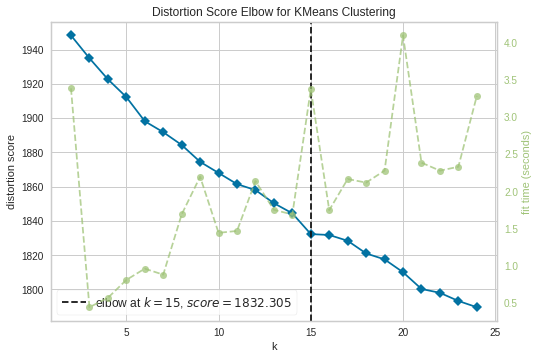

In [ ]:
model = KMeans(random_state=42)

elb_visualizer = KElbowVisualizer(model, k=(2,25))
elb_visualizer.fit(X)    
elb_visualizer.show()  

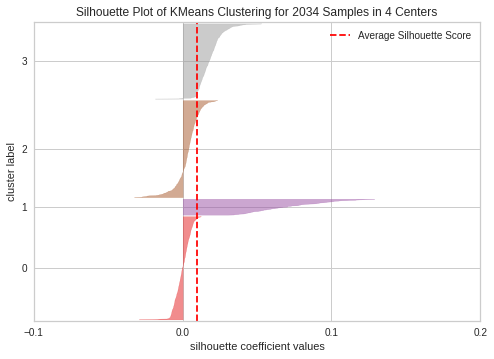

In [ ]:
model_4clust = KMeans(n_clusters = 4, random_state=42)

sil_visualizer = SilhouetteVisualizer(model_4clust)
sil_visualizer.fit(X)    
sil_visualizer.show()

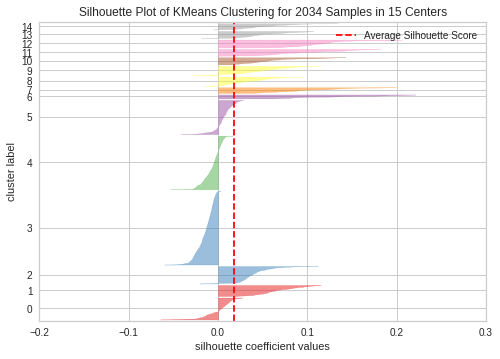

In [ ]:
model_4clust = KMeans(n_clusters = 15, random_state=42)

sil_visualizer = SilhouetteVisualizer(model_4clust)
sil_visualizer.fit(X)    
sil_visualizer.show()